tokenizing
prompt list length 24
starting training
loss continuous: 8.530298233032227loss projected: 8.526494026184082 
loss continuous: 7.628532409667969loss projected: 7.82200813293457 
loss continuous: 8.976092338562012loss projected: 9.09129524230957 
loss continuous: 7.203394412994385loss projected: 7.534895896911621 
loss continuous: 7.321535110473633loss projected: 7.620361804962158 
loss continuous: 7.427311420440674loss projected: 7.673631191253662 
loss continuous: 9.357646942138672loss projected: 9.690881729125977 
loss continuous: 8.037398338317871loss projected: 8.457508087158203 
loss continuous: 7.299705505371094loss projected: 7.975104808807373 
loss continuous: 8.268082618713379loss projected: 8.799680709838867 
loss continuous: 7.738925457000732loss projected: 8.20033073425293 
 Epoch 1/3 complete. Loss: 0.009012311137122744
loss continuous: 8.201757431030273loss projected: 8.52123737335205 
loss continuous: 7.132340431213379loss projected: 7.8079142570495605 
loss co

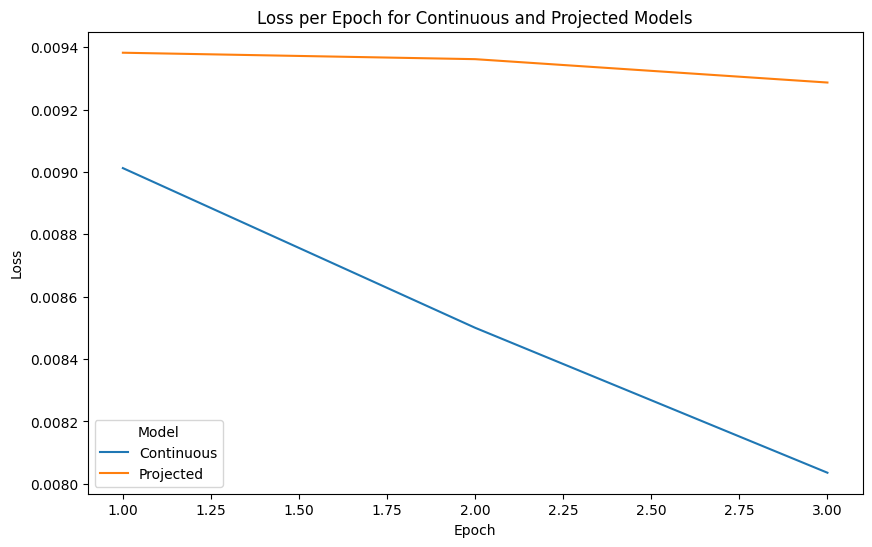

In [21]:
import torch
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Load the dataset
dataset = load_dataset('bigscience/P3', 'cos_e_v1.11_aligned_with_common_sense')
train_dataset = dataset['train']

# Initialize the tokenizer and models (one or continuous prompting and other for projected prompting
model_continuous = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')
model_projected = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_continuous.to(device)
model_projected.to(device)

# Define the prompt basis
prompt_list = [
    'When you see the following question, I would like you to answer it correctly',
    'Produce an executable artifact of type X that will answer the question, and then execute it',
    'When I ask you a question, generate three additional questions that would help you give a more accurate answer. When you then answered the three questions, combine the answers to produce the final answers to my original question',
    'Generate a set of facts that are contained in the output. The set of facts should be inserted in a specific point in the output to answer the question',
    'Given the following question, generate a detailed explanation before providing the correct answer',
    'Imagine you are a teacher explaining the answer to this question to a student. How would you respond?',
    'Consider the following question. What are the key concepts involved and how do they lead to the correct answer?',
    'As an expert in the field, how would you respond to the following question?',
    'Translate the following question into a simpler form, then provide the answer',
    'If you were to create a diagram to answer this question, what would it look like? Describe it in detail',
    'Pretend you are explaining the answer to this question to someone with no background in the subject. How would you explain it?',
    'As a highly proficient translator, translate the following question into a different context, then provide the answer',
    'Generate a step-by-step guide to answer the following question',
    'Consider the following question. What assumptions are you making in order to answer it?',
    'If you were to debate the answer to this question, what points would you raise?',
    'As a researcher, how would you investigate the answer to the following question?',
    'Pretend you are a journalist reporting on the answer to this question. How would you present it?',
    'As a storyteller, weave a narrative around the answer to this question',
    'If you were to answer this question in a court of law, what evidence would you present?',
    'As a detective, how would you piece together the answer to this question?',
    'Imagine you are a computer program designed to answer this question. What algorithms or processes would you use?',
    'As a philosopher, how would you interpret the answer to this question?',
    'If you were to answer this question in a job interview, how would you respond?',
    'As a scientist, how would you experiment to find the answer to this question?'
]

print(f'tokenizing')
print(f'prompt list length {len(prompt_list)}')

basis = tokenizer(prompt_list, padding=True, truncation=True, return_tensors='pt').to(device)
basis = model_projected.model.shared(basis.input_ids)

# print(f'prompt basis shape: {basis.shape}')

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the weight prediction model
class LearnWeights(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LearnWeights, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.layer2 = nn.Linear(512, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.output_layer(x)
        x = x.mean(dim=1, keepdim=True)  # Compute the mean across the token dimension and batch dimension
        return F.softmax(x, dim=-1).squeeze(1).mean(dim=0)
        
       
# Define the soft prompt
# we want good initialization of the soft prompt
soft_prompt = torch.mean(basis, dim=0)
soft_prompt = torch.nn.Parameter(soft_prompt)
optimizer_continuous = AdamW([soft_prompt])

# Define the projected prompt
input_dim = 1024

output_dim = len(prompt_list)
learn_weights = LearnWeights(input_dim, output_dim).to(device)
optimizer_projected = AdamW(learn_weights.parameters())

# Training parameters
epochs = 3
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('starting training')

# Training loop
continuous_losses = []
projected_losses = []

shapes = []

for epoch in range(epochs):
    epoch_loss_continuous = 0
    epoch_loss_projected = 0
    for i in range(0, len(train_dataset) - 9700, batch_size):
        batch = train_dataset[i:i+batch_size]
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_continuous.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)
        
        #print(f'input embeddings shape: {input_embeddings.shape}')
    

        # add copies of soft prompt for each element in the batch
        soft_prompt_batch = soft_prompt.unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        
        # print(f'soft prompt shape: {soft_prompt.shape}')
        #the goal is to have good initizlization of the soft prompt
        
        # add copies of projected prompt for each element in the batch
        #print(f'basis shape: {basis.shape}')
        
        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')
        
        combined_continuous_embeddings = torch.cat([soft_prompt_batch, input_embeddings], dim=1)
        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)

        # Pass the combined embeddings through the model
        outputs_continuous = model_continuous(inputs_embeds=combined_continuous_embeddings, labels=labels)
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)

        loss_continuous = outputs_continuous.loss
        epoch_loss_continuous += loss_continuous.item()

        loss_projected = outputs_projected.loss
        epoch_loss_projected += loss_projected.item()

        optimizer_continuous.zero_grad()
        loss_continuous.backward(retain_graph=True)
        optimizer_continuous.step()

        optimizer_projected.zero_grad()
        loss_projected.backward(retain_graph=True)
        optimizer_projected.step()

        #print(f'complete from this epoch {i}/{len(train_dataset)}', end='')
        print(f'loss continuous: {loss_continuous.item()}', end='')
        print(f'loss projected: {loss_projected.item()} \n', end='')

    epoch_loss_continuous /= len(train_dataset)
    epoch_loss_projected /= len(train_dataset)

    continuous_losses.append(epoch_loss_continuous)
    projected_losses.append(epoch_loss_projected)

    print(f'\r Epoch {epoch+1}/{epochs} complete. Loss: {epoch_loss_continuous}')


# Create a DataFrame with the loss values
data = {
    'Epoch': list(range(1, epochs + 1)) * 2,
    'Loss': continuous_losses + projected_losses,
    'Model': ['Continuous'] * epochs + ['Projected'] * epochs
}
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epoch', y='Loss', hue='Model')
plt.title('Loss per Epoch for Continuous and Projected Models')
plt.show()